In [13]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from IPython.html import widgets
from IPython.display import display, clear_output

from screen_utils import *
from cv_utils import *

In [14]:
def gen_training_data(fps, video_len, initial_wait=1.5):
    time.sleep(initial_wait)
    
    window_coords = get_window_coords()
    window_width = window_coords[2] - window_coords[0]
    window_height = window_coords[3] - window_coords[1]

    tracker = ObjectTracker(300, 3000, time_threshold=2, n_hist=4,
                            stationary_threshold=5)

    train_image_buffer = []
    
    for i in range(int(video_len * fps)):
        prev_time = time.time()
        window_pixels = grab_area(*window_coords)
        mask = get_cow_mask(window_pixels)
        
        bounding_boxes = get_bounding_boxes(mask)
        objects = tracker.add_frame(bounding_boxes)

        obj_centers = set(objects.values())
        for bounding_box in bounding_boxes:
            if bounding_box[0] in obj_centers:
                x, y, width, height = bounding_box[1]
                cropped_img = window_pixels[y:y+height, x:x+width]
                if 0 in cropped_img.shape:
                    print(cropped_img.shape, bounding_box[1])
                train_image_buffer.append(cropped_img)

        while time.time() - prev_time < 1./fps:
            time.sleep(0.001)
            
    return train_image_buffer

In [15]:
FPS = 1
VIDEO_LEN = 180 # Seconds
train_imgs = gen_training_data(FPS, VIDEO_LEN, initial_wait=1.5)

In [16]:
len(train_imgs)

2196

Button(description='Cow', style=ButtonStyle())

Button(description='NOT Cow', style=ButtonStyle())

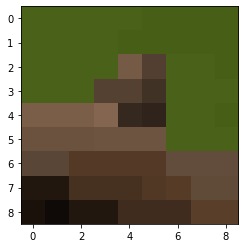

In [17]:
img_idx = 0
cow_idx = 0
not_cow_idx = 0
labels = []

cow_button = widgets.Button(description='Cow')
not_cow_button = widgets.Button(description='NOT Cow')

def display_next():
    global img_idx
    
    clear_output()
    plt.imshow(train_imgs[img_idx])
    
    display(cow_button)
    display(not_cow_button)
    
display_next()

def on_cow_click(b):
    global img_idx
    global cow_idx
    
    labels.append(1)
    cv2.imwrite(f'data/cow/cow_{cow_idx}.png', cv2.cvtColor(train_imgs[img_idx], cv2.COLOR_RGB2BGR))
    
    img_idx += 1
    cow_idx += 1
    
    display_next()
    
def on_not_cow_click(b):
    global img_idx
    global not_cow_idx
    
    labels.append(0)
    cv2.imwrite(f'data/not_cow/not_cow_{not_cow_idx}.png', cv2.cvtColor(train_imgs[img_idx], cv2.COLOR_RGB2BGR))
    
    img_idx += 1
    not_cow_idx += 1
    
    display_next()
    
cow_button.on_click(on_cow_click)
not_cow_button.on_click(on_not_cow_click)